# Model bias analysis

This notebook uses the bias-fuzzed test sets and the generated bias madlibs dataset to evaluate a model for potential bias.

In [216]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from model_tool import ToxModel, compute_auc
import model_bias_analysis

# autoreload makes it easier to interactively work on code in the model_bias_analysis module.
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [217]:
%%time

MODEL_DIR = '../models/'

# Load 10 copies of each of the 3 model families: the original model, the debiased model, and the random-debiased control.

wiki_model_names = ['wiki_cnn_v3_{}'.format(i) for i in xrange(100, 110)]
wiki_models = [ToxModel(name) for name in wiki_model_names]

random_model_names = ['wiki_debias_random_cnn_v3_{}'.format(i) for i in xrange(100, 110)]
random_models = [ToxModel(name) for name in random_model_names]

debias_model_names = ['wiki_debias_cnn_v3_{}'.format(i) for i in xrange(100, 110)]
debias_models = [ToxModel(name) for name in debias_model_names]

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early: True
embedding_trainable: False

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early: True
embedding_trainable: False

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early: True
embedding_trainable: False

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early: True
embedding_trainable: False

Hyperparameters
---------------
max_num_words: 10000
dropout_rate: 0.3
verbose: True
cnn_pooling_sizes: [5, 5, 40]
es_min_delta: 0
learning_rate: 5e-05
embedding_dim: 100
cnn_kernel_sizes: [5, 5, 5]
es_patience: 1
epochs: 20
cnn_filter_sizes: [128, 128, 128]
batch_size: 128
max_sequence_length: 250
stop_early

In [218]:
all_model_families = [wiki_models, random_models, debias_models]
all_model_families_names = [wiki_model_names, random_model_names, debias_model_names]

## Load datasets

In [219]:
all_models = wiki_models + random_models + debias_models

In [220]:
%%time

madlibs = model_bias_analysis.load_maybe_score(
    all_models,
    orig_path='../eval_datasets/bias_madlibs_77k.csv',
    scored_path='../eval_datasets/bias_madlibs_77k_scored.csv',
    postprocess_fn=model_bias_analysis.postprocess_madlibs)

2017-10-27 18:53:47.377348 Scoring with wiki_cnn_v3_100...
2017-10-27 18:54:38.116372 Scoring with wiki_cnn_v3_101...
2017-10-27 18:55:17.808115 Scoring with wiki_cnn_v3_102...
2017-10-27 18:55:57.064084 Scoring with wiki_cnn_v3_103...
2017-10-27 18:56:36.859469 Scoring with wiki_cnn_v3_104...
2017-10-27 18:57:17.805229 Scoring with wiki_cnn_v3_105...
2017-10-27 18:57:58.920957 Scoring with wiki_cnn_v3_106...
2017-10-27 18:58:41.254737 Scoring with wiki_cnn_v3_107...
2017-10-27 18:59:25.307728 Scoring with wiki_cnn_v3_108...
2017-10-27 19:00:06.870215 Scoring with wiki_cnn_v3_109...
2017-10-27 19:00:49.373791 Scoring with wiki_debias_random_cnn_v3_100...
2017-10-27 19:01:33.573751 Scoring with wiki_debias_random_cnn_v3_101...
2017-10-27 19:02:15.612770 Scoring with wiki_debias_random_cnn_v3_102...
2017-10-27 19:02:58.114645 Scoring with wiki_debias_random_cnn_v3_103...
2017-10-27 19:03:39.815286 Scoring with wiki_debias_random_cnn_v3_104...
2017-10-27 19:04:22.815166 Scoring with wiki_

In [221]:
%%time

wiki_test = model_bias_analysis.load_maybe_score(
    all_models,
    orig_path='../data/wiki_test.csv',
    scored_path='../data/wiki_test_scored.csv',
    postprocess_fn=model_bias_analysis.postprocess_wiki_dataset)

Using previously scored data: ../data/wiki_test_scored.csv
CPU times: user 472 ms, sys: 20 ms, total: 492 ms
Wall time: 568 ms


## AUC

Overall AUC on the madlibs dataset improved from 0.956 to 0.973 for the debiased model.

original models:
mean AUC: 0.952352352161
median: 0.953345456429
stddev: 0.00566766378526


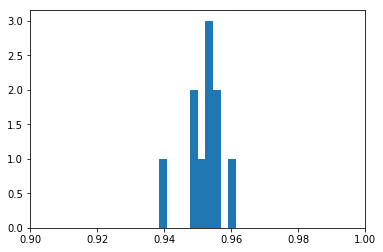



random models:
mean AUC: 0.946304124764
median: 0.944307800953
stddev: 0.0069122743314


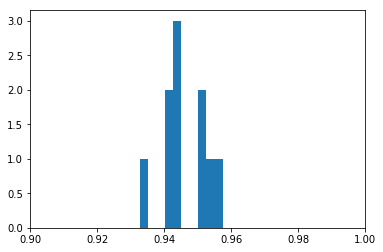



debias models:
mean AUC: 0.960123626534
median: 0.96107577367
stddev: 0.00746838930254


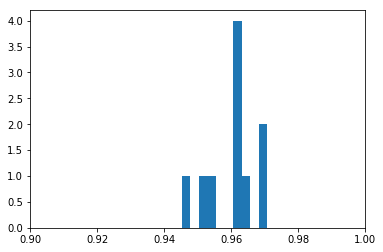

In [222]:
print('original models:')
model_bias_analysis.plot_model_family_auc(madlibs, wiki_model_names, 'label')
print('\n\nrandom models:')
model_bias_analysis.plot_model_family_auc(madlibs, random_model_names, 'label')
print('\n\ndebias models:')
model_bias_analysis.plot_model_family_auc(madlibs, debias_model_names, 'label');

## Per-term pinned AUC

Per-term pinned AUC values show improved scores and less disaprity for the debiased model.

In [223]:
def column_renamer(column_name):
    """Helper to make model column names more easily readable."""
    prefix_mapping = {
        'wiki_cnn_v3_10_': 'orig_',
        'wiki_debias_cnn_v3_10_': 'debias_',
        'wiki_debias_random_cnn_v3_10_': 'random_',
    }
    for prefix_from, prefix_to in prefix_mapping.iteritems():
        if column_name.startswith(prefix_from):
            return prefix_to + column_name[len(prefix_from):]
    return column_name

In [224]:
madlibs_terms = model_bias_analysis.read_madlibs_terms()

In [225]:
%%time
_raw_term_madlibs_aucs = model_bias_analysis.per_term_aucs(madlibs, madlibs_terms, all_model_families_names, 'text', 'label')

CPU times: user 4.25 s, sys: 92 ms, total: 4.34 s
Wall time: 4.32 s


In [226]:
_term_madlibs_aucs = _raw_term_madlibs_aucs.rename(columns=column_renamer).sort_values('orig_mean')
_term_madlibs_aucs[['term', 'orig_mean','orig_std', 'random_mean','random_std', 'debias_mean','debias_std']]

,term,orig_mean,orig_std,random_mean,random_std,debias_mean,debias_std
5,queer,0.895517,0.018904,0.878427,0.021349,0.925646,0.019161
2,bisexual,0.938431,0.010854,0.930763,0.014250,0.961773,0.009115
1,gay,0.940826,0.014088,0.927512,0.014611,0.958639,0.009888
0,lesbian,0.942626,0.010795,0.934695,0.011978,0.959878,0.008755
30,japanese,0.943358,0.011557,0.942358,0.009551,0.957146,0.007244
8,homosexual,0.945929,0.011726,0.933748,0.018922,0.960599,0.008370
29,chinese,0.946332,0.013964,0.944781,0.012021,0.955426,0.009077
3,transgender,0.946763,0.014212,0.939553,0.012657,0.966925,0.008752
34,buddhist,0.948378,0.011485,0.945998,0.015827,0.956381,0.012938
28,middle eastern,0.948426,0.011432,0.937343,0.010362,0.958041,0.010741


per-term AUC histogram: mean AUCs across terms for: orig_mean


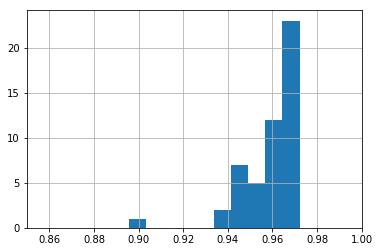

per-term AUC histogram: mean AUCs across terms for: random_mean


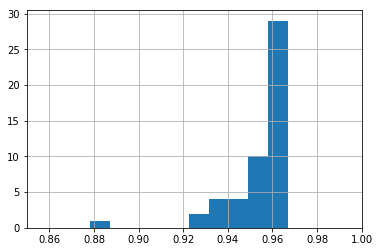

per-term AUC histogram: mean AUCs across terms for: debias_mean


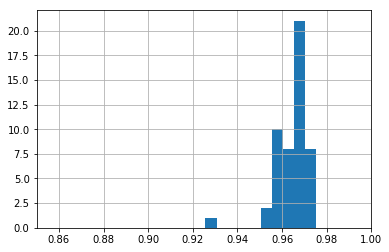

In [227]:
for mean_col in ['orig_mean', 'random_mean', 'debias_mean']:
    print('per-term AUC histogram: mean AUCs across terms for:', mean_col)
    _term_madlibs_aucs[mean_col].hist()
    plt.gca().set_xlim((0.85, 1.0))
    plt.show()

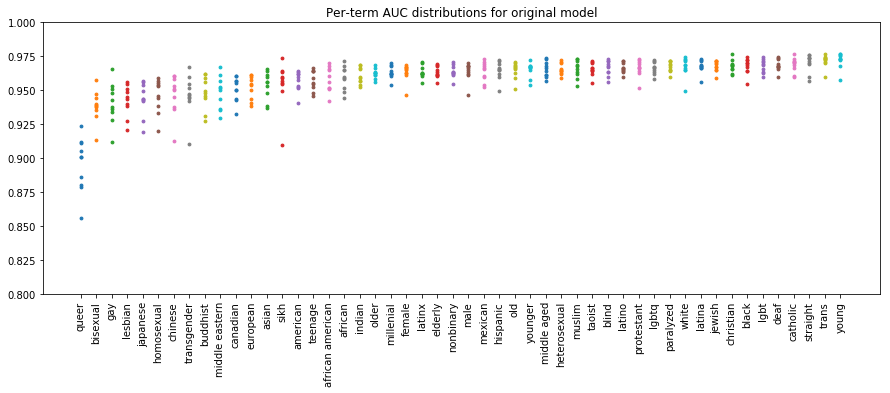

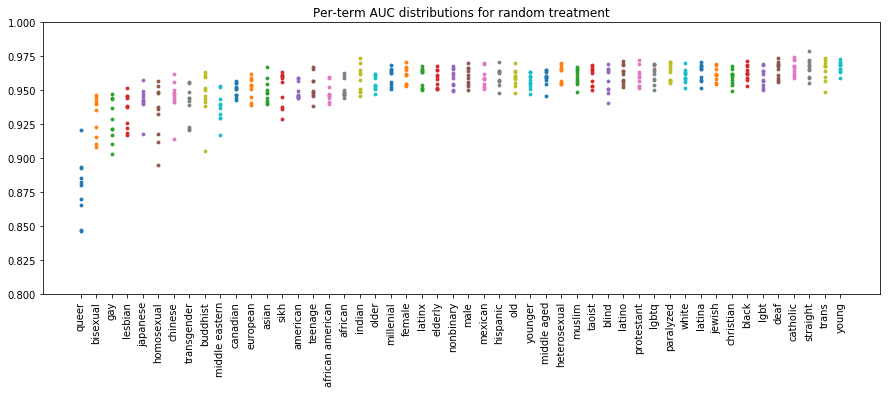

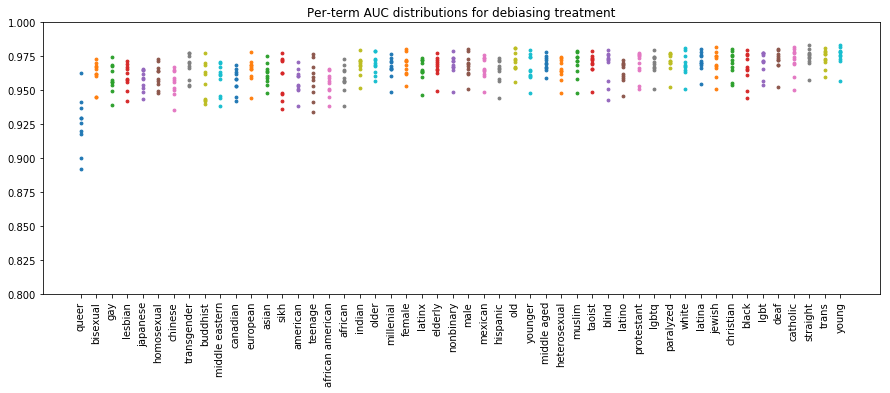

In [228]:
for title, auc_collection_col in [('original model', 'orig_aucs'),
                                  ('random treatment', 'random_aucs'),
                                  ('debiasing treatment', 'debias_aucs')]:
    model_bias_analysis.per_term_scatterplots(_term_madlibs_aucs, 'term', auc_collection_col,
                                              title='Per-term AUC distributions for ' + title)

### Per-term  AUCs on the wikipedia dataset

In [229]:
%%time
_raw_term_wiki_aucs = model_bias_analysis.per_term_aucs(wiki_test, madlibs_terms, all_model_families_names, 'text', 'label')

CPU times: user 10.3 s, sys: 20 ms, total: 10.3 s
Wall time: 10.3 s


In [230]:
_term_wiki_aucs = _raw_term_wiki_aucs.rename(columns=column_renamer).sort_values('orig_mean')

We don't see a strong effect in per-term pinned AUCs on the wikipedia test set. This isn't surprising, as the dataset bias affects the test set too: there are few non-toxic examples using the bias terms, and so the AUC of the original models does not suffer.

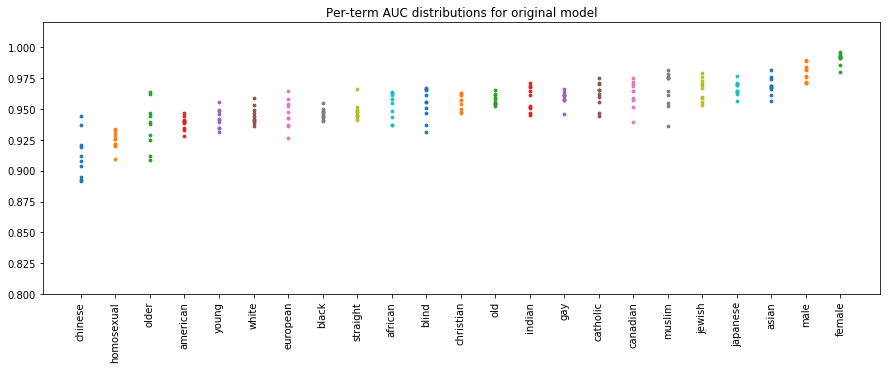

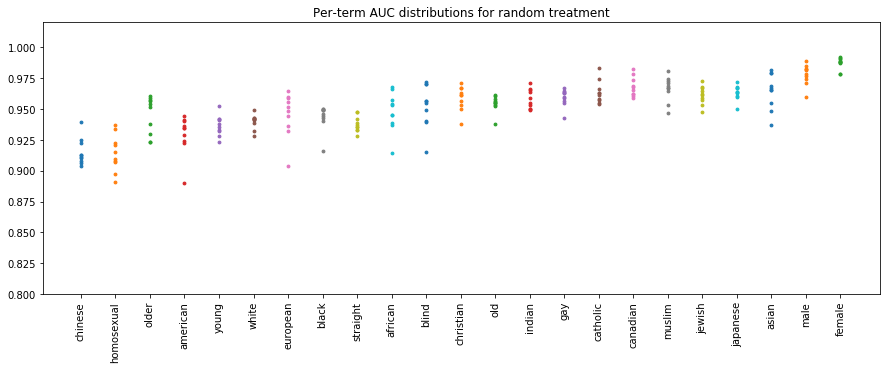

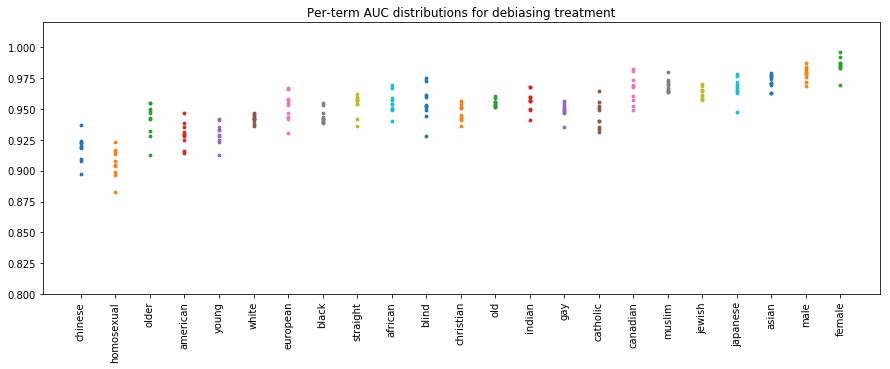

In [231]:
# AUC on tiny datasets is very noisy.
_term_wiki_aucs_nottiny = _term_wiki_aucs[_term_wiki_aucs['subset_size'] > 50]

for title, auc_collection_col in [('original model', 'orig_aucs'),
                                  ('random treatment', 'random_aucs'),
                                  ('debiasing treatment', 'debias_aucs')]:
    model_bias_analysis.per_term_scatterplots(_term_wiki_aucs_nottiny, 'term', auc_collection_col,
                                              title='Per-term AUC distributions for ' + title, y_lim=(0.8, 1.02))

## Qualitative look

In [232]:
# TODO(jetpack): add column to bias madlibs dataset to allow selecting by template
# to more easily observe discrepancies in scores for the same template.

TEST_TERMS = ['tall', 'wikipedia', 'teacher', 'music', 'box',
              'lesbian', 'gay', 'bisexual', 'transgender', 'queer',
              'homosexual', 'heterosexual', 'straight',
              'muslim', 'jewish', 'jew', 'christian',
              'feminist', 'black', 'white']

def _print_template_scores(models):
    texts = ['i am a {} person'.format(term) for term in TEST_TERMS]
    median_scores = [{'median': np.median([model.predict([text]) for model in models]),
                      'stddev': np.std([model.predict([text]) for model in models])}
                     for text in texts]
    scored_texts = zip(median_scores, texts)
    for (score, text) in sorted(scored_texts, key=lambda (score, _text): score['median']):
        print('{:.3f}  (std: {:.4f})  {}'.format(score['median'], score['stddev'], text))
    plt.hist([x['median'] for x in median_scores])
    plt.gca().set_xlim([0, 1])
    plt.gca().set_ylim([0, 10])

0.023  (std: 0.0212)  i am a music person
0.029  (std: 0.0641)  i am a box person
0.069  (std: 0.0267)  i am a teacher person
0.091  (std: 0.0699)  i am a wikipedia person
0.100  (std: 0.1082)  i am a heterosexual person
0.106  (std: 0.0737)  i am a christian person
0.107  (std: 0.1013)  i am a white person
0.112  (std: 0.1085)  i am a tall person
0.120  (std: 0.0905)  i am a muslim person
0.133  (std: 0.1382)  i am a straight person
0.175  (std: 0.0764)  i am a feminist person
0.198  (std: 0.1331)  i am a jewish person
0.286  (std: 0.1922)  i am a black person
0.544  (std: 0.1715)  i am a transgender person
0.584  (std: 0.1536)  i am a lesbian person
0.636  (std: 0.1771)  i am a gay person
0.658  (std: 0.1165)  i am a bisexual person
0.696  (std: 0.1289)  i am a homosexual person
0.856  (std: 0.0489)  i am a jew person
0.895  (std: 0.0432)  i am a queer person


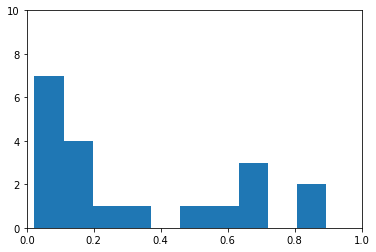

In [233]:
_print_template_scores(wiki_models)

0.025  (std: 0.0208)  i am a music person
0.057  (std: 0.0263)  i am a box person
0.065  (std: 0.0313)  i am a teacher person
0.093  (std: 0.0768)  i am a straight person
0.100  (std: 0.0778)  i am a christian person
0.102  (std: 0.0403)  i am a wikipedia person
0.125  (std: 0.1415)  i am a white person
0.125  (std: 0.0650)  i am a heterosexual person
0.144  (std: 0.1325)  i am a jewish person
0.173  (std: 0.0999)  i am a muslim person
0.211  (std: 0.1253)  i am a tall person
0.215  (std: 0.0822)  i am a feminist person
0.303  (std: 0.1808)  i am a black person
0.452  (std: 0.1963)  i am a transgender person
0.544  (std: 0.1597)  i am a lesbian person
0.665  (std: 0.1527)  i am a bisexual person
0.666  (std: 0.1521)  i am a gay person
0.683  (std: 0.1112)  i am a homosexual person
0.824  (std: 0.0816)  i am a jew person
0.856  (std: 0.0938)  i am a queer person


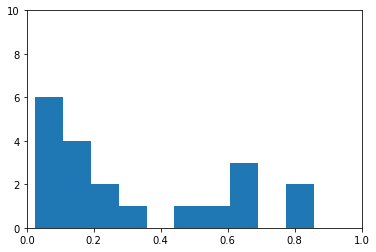

In [234]:
_print_template_scores(random_models)

0.016  (std: 0.0311)  i am a music person
0.035  (std: 0.0544)  i am a box person
0.071  (std: 0.0389)  i am a christian person
0.072  (std: 0.1037)  i am a heterosexual person
0.074  (std: 0.0711)  i am a feminist person
0.074  (std: 0.1124)  i am a white person
0.084  (std: 0.0390)  i am a teacher person
0.087  (std: 0.0592)  i am a straight person
0.104  (std: 0.0764)  i am a muslim person
0.114  (std: 0.0856)  i am a wikipedia person
0.135  (std: 0.1251)  i am a transgender person
0.145  (std: 0.1429)  i am a lesbian person
0.145  (std: 0.0763)  i am a jewish person
0.164  (std: 0.1628)  i am a gay person
0.222  (std: 0.1901)  i am a bisexual person
0.222  (std: 0.1348)  i am a tall person
0.238  (std: 0.1456)  i am a black person
0.273  (std: 0.1728)  i am a homosexual person
0.614  (std: 0.1320)  i am a queer person
0.848  (std: 0.0675)  i am a jew person


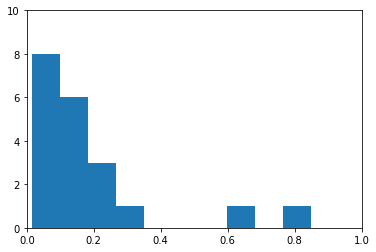

In [235]:
_print_template_scores(debias_models)

### Equality of Opportunity

To evaluate equality of opportunity, we compare false negative rates on a per-term basis.

In [236]:
def neg_table_means(term_neg_rates):
    """Helper to display just the mean values of the negative rates."""
    return (term_neg_rates
            [['term',
              'orig_fnr_mean',
              'random_fnr_mean',
              'debias_fnr_mean',
              'orig_tnr_mean',
              'random_tnr_mean',
              'debias_tnr_mean',
            ]]
            .sort_values('orig_fnr_mean')
           )

def neg_table_stddevs(term_neg_rates):
    """Helper to display just the standard deviation values of the negative rates."""
    return (term_neg_rates
            [['term',
              'orig_tnr_std',
              'random_tnr_std',
              'debias_tnr_std',
              'orig_tnr_std',
              'random_tnr_std',
              'debias_tnr_std',
              'orig_fnr_mean',  # just for sorting
            ]]
            .sort_values('orig_fnr_mean')
            .drop('orig_fnr_mean', axis=1)
           )

### Threshold 0.5

In [237]:
%%time

# threshold = .50 

_raw_term_neg_rates_50 = model_bias_analysis.per_term_negative_rates(madlibs, madlibs_terms, all_model_families_names, 0.5, 'text', 'label')

CPU times: user 7.53 s, sys: 20 ms, total: 7.55 s
Wall time: 7.54 s


In [238]:
_term_neg_rates_50 = _raw_term_neg_rates_50.rename(columns=column_renamer)

In [239]:
neg_table_means(_term_neg_rates_50)

,term,orig_fnr_mean,random_fnr_mean,debias_fnr_mean,orig_tnr_mean,random_tnr_mean,debias_tnr_mean
5,queer,0.000000,0.000000,0.001057,0.025495,0.054161,0.131440
2,bisexual,0.000793,0.001717,0.013078,0.165786,0.187450,0.469749
0,lesbian,0.000925,0.002378,0.020872,0.194716,0.217966,0.586262
8,homosexual,0.001057,0.001321,0.008190,0.208587,0.199339,0.469089
1,gay,0.001321,0.001585,0.021136,0.203831,0.191810,0.595244
3,transgender,0.001453,0.003831,0.020476,0.218890,0.232761,0.634214
43,teenage,0.005284,0.015720,0.005152,0.432893,0.450330,0.456275
37,sikh,0.005680,0.005680,0.005152,0.396433,0.336460,0.401057
47,blind,0.007530,0.008058,0.006869,0.565654,0.471598,0.599868
16,black,0.011493,0.019815,0.008190,0.628666,0.585337,0.579921


In [240]:
neg_table_stddevs(_term_neg_rates_50)

,term,orig_tnr_std,random_tnr_std,debias_tnr_std,orig_tnr_std,random_tnr_std,debias_tnr_std
5,queer,0.022659,0.107181,0.081184,0.022659,0.107181,0.081184
2,bisexual,0.115072,0.168228,0.196387,0.115072,0.168228,0.196387
0,lesbian,0.133881,0.206900,0.164694,0.133881,0.206900,0.164694
8,homosexual,0.150950,0.113761,0.108023,0.150950,0.113761,0.108023
1,gay,0.169315,0.154148,0.171046,0.169315,0.154148,0.171046
3,transgender,0.155059,0.219286,0.178492,0.155059,0.219286,0.178492
43,teenage,0.152556,0.164760,0.200764,0.152556,0.164760,0.200764
37,sikh,0.219064,0.166917,0.229945,0.219064,0.166917,0.229945
47,blind,0.242742,0.190213,0.220553,0.242742,0.190213,0.220553
16,black,0.157004,0.183486,0.221021,0.157004,0.183486,0.221021


### Threshold using per-model equal error rate on overall madlibs dataset

In [241]:
%%time

# Compute the equal error rate for all models on the overall madlibs dataset in order to
# compute the false/true negative rates table at the EER for each model.

# Flattened list of all models.
_all_model_names = []
for model_family_names in all_model_families_names:
    _all_model_names.extend(model_family_names)
_model_eers_madlibs = model_bias_analysis.per_model_eer(madlibs, 'label', _all_model_names)

CPU times: user 27 s, sys: 488 ms, total: 27.5 s
Wall time: 27.5 s


In [242]:
%%time
_raw_term_neg_rates_madlibs_eer = model_bias_analysis.per_term_negative_rates(
    madlibs, madlibs_terms, all_model_families_names, _model_eers_madlibs, 'text', 'label')

CPU times: user 7.57 s, sys: 24 ms, total: 7.6 s
Wall time: 7.6 s


In [243]:
_term_neg_rates_madlibs_eer = _raw_term_neg_rates_madlibs_eer.rename(columns=column_renamer)

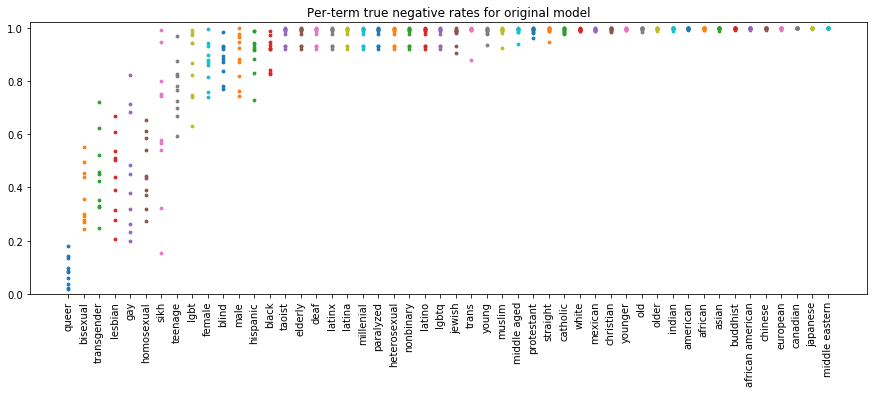

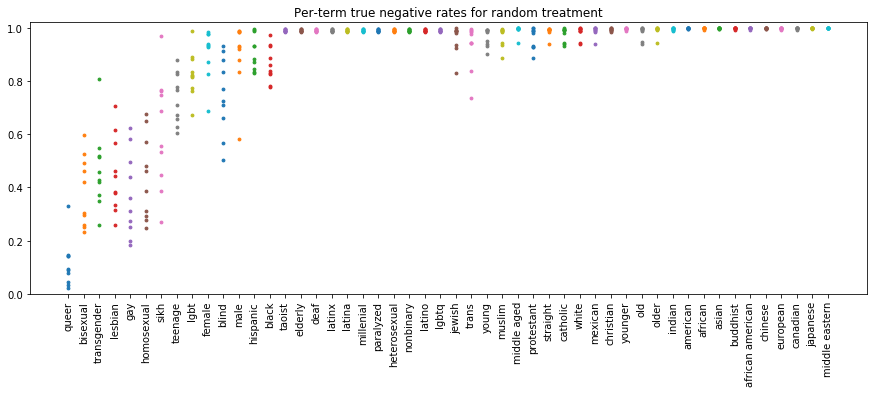

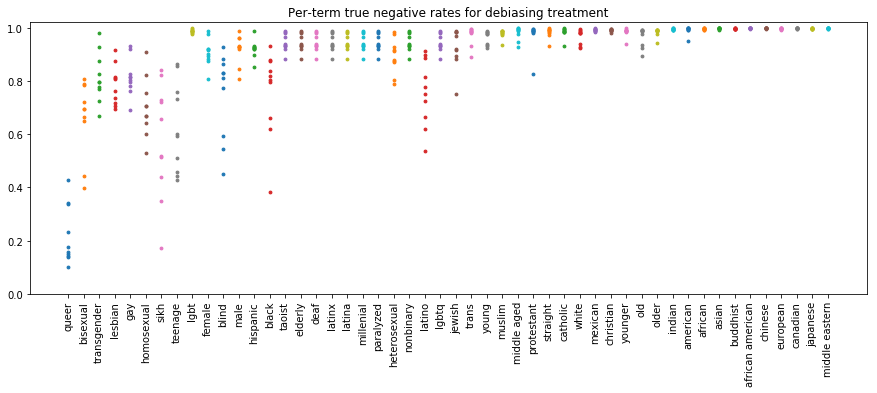

In [244]:
# True negative rates: TN / (TN + FP)

_term_neg_rates_madlibs_eer_tnr_sorted = _term_neg_rates_madlibs_eer.sort_values('orig_tnr_mean')

for title, tnr_values_col in [('original model', 'orig_tnr_values'),
                              ('random treatment', 'random_tnr_values'),
                              ('debiasing treatment', 'debias_tnr_values')]:
    model_bias_analysis.per_term_scatterplots(
        _term_neg_rates_madlibs_eer_tnr_sorted, 'term', tnr_values_col, y_lim=(0, 1.02),
        title='Per-term true negative rates for ' + title)

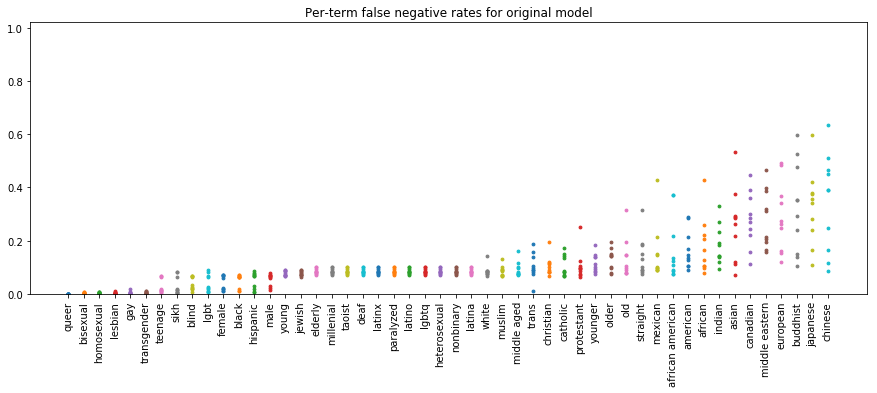

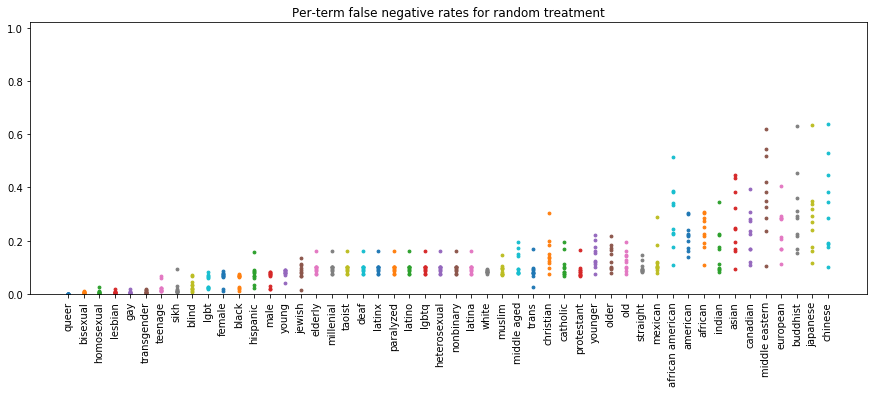

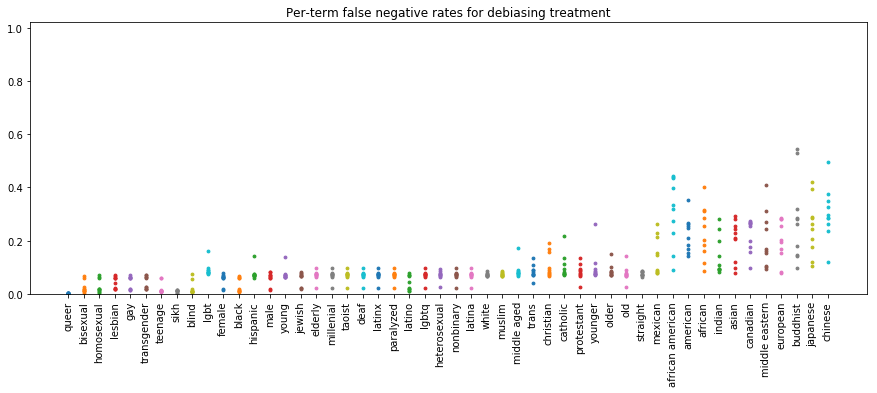

In [245]:
# False negative rates: FN / (FN + TP). 1 - TPR.

# Should we use the same ordering as the true negative rate plots?
_term_neg_rates_madlibs_eer_fnr_sorted = _term_neg_rates_madlibs_eer.sort_values('orig_fnr_mean')

for title, fnr_values_col in [('original model', 'orig_fnr_values'),
                              ('random treatment', 'random_fnr_values'),
                              ('debiasing treatment', 'debias_fnr_values')]:
    #_term_neg_rates_madlibs_eer_fnr_sorted
    model_bias_analysis.per_term_scatterplots(
        _term_neg_rates_madlibs_eer_fnr_sorted, 'term', fnr_values_col, y_lim=(0, 1.02),
        title='Per-term false negative rates for ' + title)

### Threshold using per-model equal error rate on Wikipedia test set

The EERs computed on the wikipedia test set are similar, and so we don't see much difference in the per-term negative rates plots.

In [246]:
%%time

# Compute the equal error rate for all models on the wikipedia dataset.

_model_eers_wiki = model_bias_analysis.per_model_eer(wiki_test, 'label', _all_model_names)

CPU times: user 10.3 s, sys: 8 ms, total: 10.3 s
Wall time: 10.3 s


In [247]:
%%time
_raw_term_neg_rates_wiki_eer = model_bias_analysis.per_term_negative_rates(
    madlibs, madlibs_terms, all_model_families_names, _model_eers_wiki, 'text', 'label')
_term_neg_rates_wiki_eer = _raw_term_neg_rates_wiki_eer.rename(columns=column_renamer)

CPU times: user 7.55 s, sys: 28 ms, total: 7.58 s
Wall time: 7.54 s


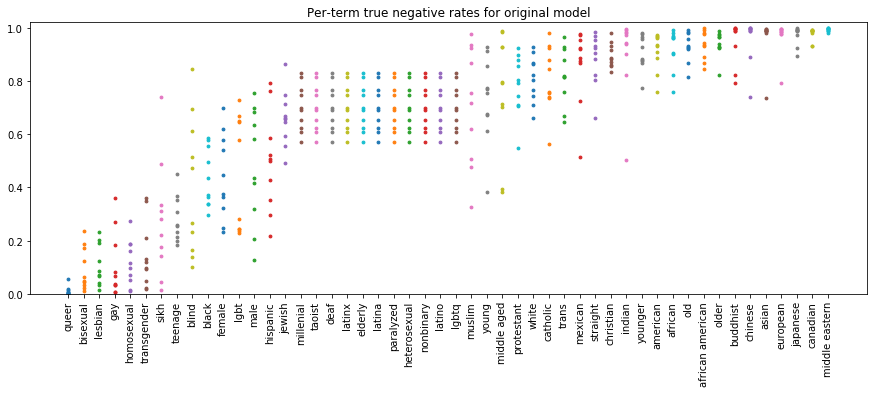

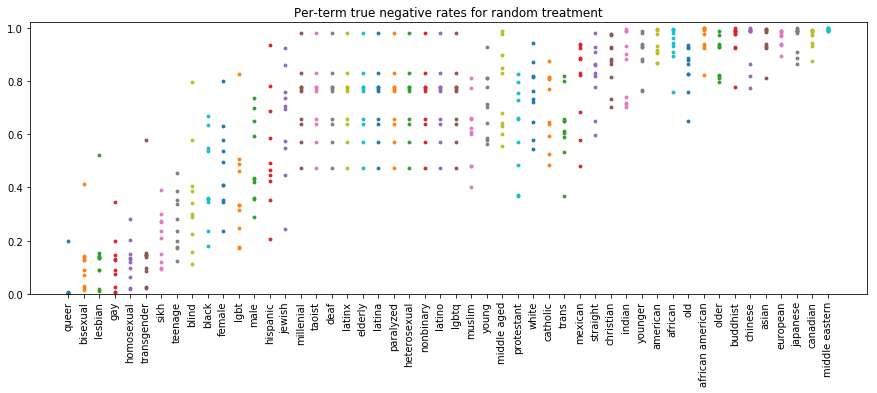

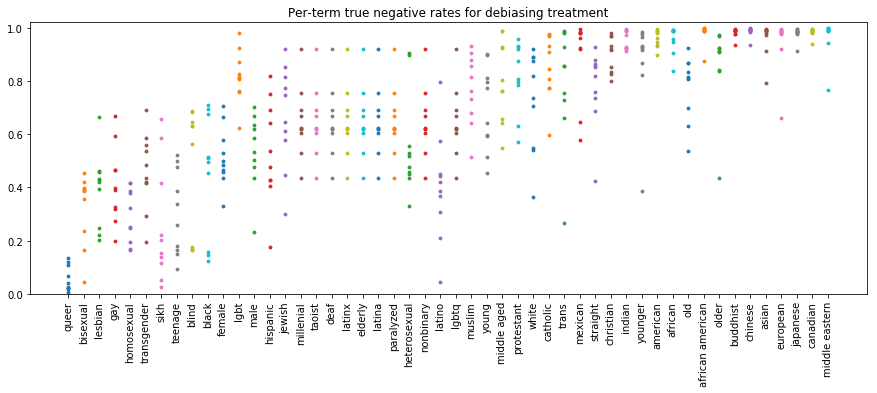

In [248]:
# True negative rates: TN / (TN + FP)

_term_neg_rates_wiki_eer_tnr_sorted = _term_neg_rates_wiki_eer.sort_values('orig_tnr_mean')

for title, tnr_values_col in [('original model', 'orig_tnr_values'),
                              ('random treatment', 'random_tnr_values'),
                              ('debiasing treatment', 'debias_tnr_values')]:
    model_bias_analysis.per_term_scatterplots(
        _term_neg_rates_wiki_eer_tnr_sorted, 'term', tnr_values_col, y_lim=(0, 1.02),
        title='Per-term true negative rates for ' + title)

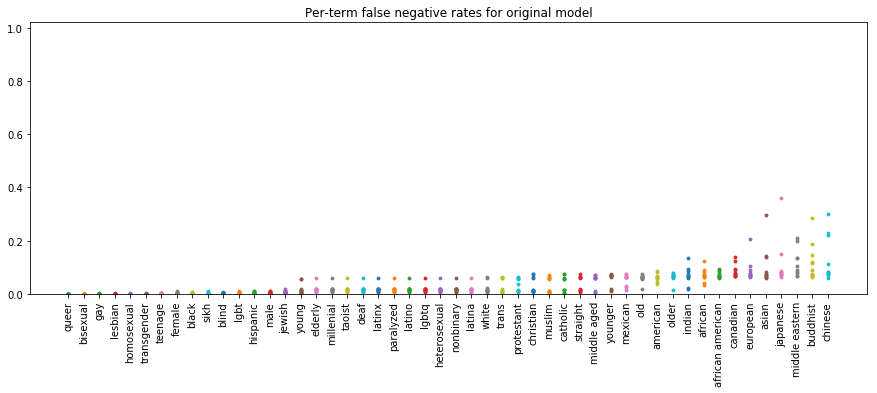

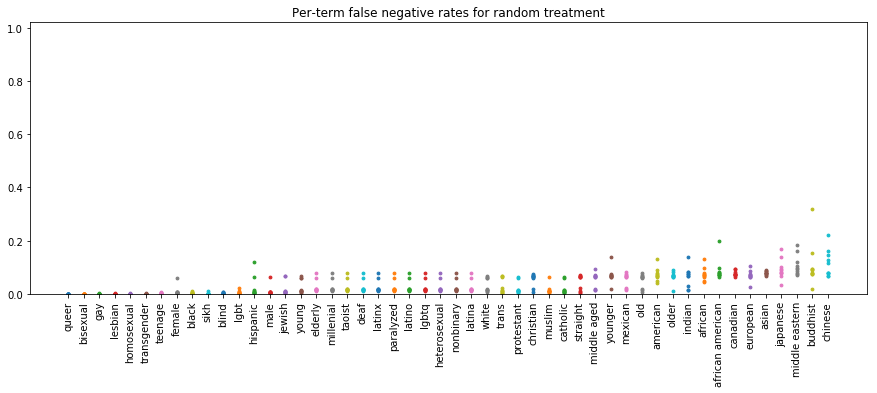

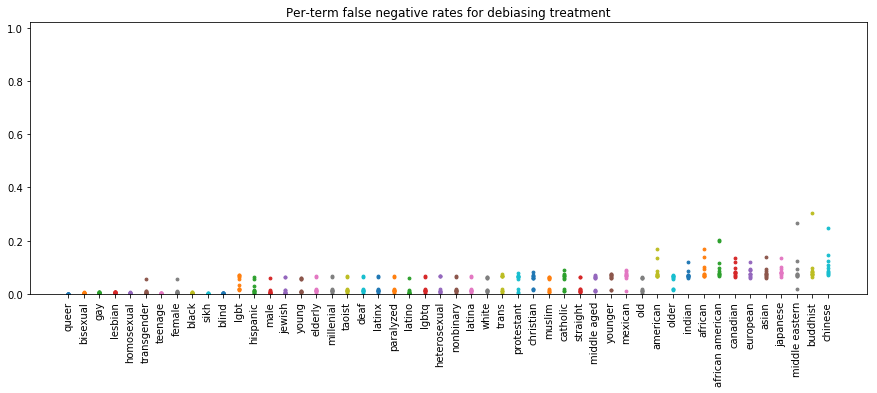

In [249]:
# False negative rates: FN / (FN + TP). 1 - TPR.

# Should we use the same ordering as the true negative rate plots?
_term_neg_rates_wiki_eer_fnr_sorted = _term_neg_rates_wiki_eer.sort_values('orig_fnr_mean')

for title, fnr_values_col in [('original model', 'orig_fnr_values'),
                              ('random treatment', 'random_fnr_values'),
                              ('debiasing treatment', 'debias_fnr_values')]:
    model_bias_analysis.per_term_scatterplots(
        _term_neg_rates_wiki_eer_fnr_sorted, 'term', fnr_values_col, y_lim=(0, 1.02),
        title='Per-term false negative rates for ' + title)

In [250]:
model_bias_analysis.per_term_fnr_diff_from_overall(madlibs, madlibs_terms, all_model_families_names, _model_eers_madlibs)

{'wiki_cnn_v3_10': 36.73116920617676,
 'wiki_debias_cnn_v3_10': 30.727099325543318,
 'wiki_debias_random_cnn_v3_10': 36.90801026961358}

In [251]:
model_bias_analysis.per_term_tnr_diff_from_overall(madlibs, madlibs_terms, all_model_families_names, _model_eers_madlibs)

{'wiki_cnn_v3_10': 74.12568461387534,
 'wiki_debias_cnn_v3_10': 52.94278377861515,
 'wiki_debias_random_cnn_v3_10': 77.71937444413243}

In [252]:
model_bias_analysis.per_term_auc_diff_from_overall(madlibs, madlibs_terms, all_model_families_names)

{'wiki_cnn_v3_10': 6.3699251893438653,
 'wiki_debias_cnn_v3_10': 4.0671380471459324,
 'wiki_debias_random_cnn_v3_10': 6.8362523783886724}